In [2]:
# Para instalar python_speech_features utilice en la consola de Python:
# pip install python_speech_features

# Para instalar el paquete de reconocimiento de voz
# pip3 install hmmlearn

# EJECUTAR EL CÓDIGO
# Este programa se debe ejecutar en la consola de Python
# Para ello utilice el siguiente comando:

# python reconocer_texto.py --input-folder data

# NOTA: El programa: reconocer_texto.py se incluye en la carpeta
# NOTA: Al final de este documento se incluye una imagen de ejecución

import os
import argparse 
import warnings

import numpy as np
from scipy.io import wavfile 

from hmmlearn import hmm
from python_speech_features import mfcc

# Define una función para analizar los argumentos de entrada
def build_arg_parser():
    parser = argparse.ArgumentParser(description='Trains the HMM-based speech \
            recognition system')
    parser.add_argument("--input-folder", dest="input_folder", required=True,
            help="Input folder containing the audio files for training")
    return parser

# Define una clase para entrenar el HMM
class ModelHMM(object):
    def __init__(self, num_components=4, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter

        self.cov_type = 'diag' 
        self.model_name = 'GaussianHMM' 

        self.models = []

        self.model = hmm.GaussianHMM(n_components=self.n_components, 
                covariance_type=self.cov_type, n_iter=self.n_iter)

    # 'training_data' es un array numpy 2D donde cada fila es 13-dimensional
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # corre el modelo HMM para realizar inferencia sobre la entrada de datos
    def compute_score(self, input_data):
        return self.model.score(input_data)

# Define una función para construir un modelo para cada palabra
def build_models(input_folder):
    
    # Inicializar la variable para almacenar todos los modelos
    speech_models = []

    # Analiza el directorio de entrada
    for dirname in os.listdir(input_folder):
        # Obtiene el nombre del subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder): 
            continue

        # Extrae la etiqueta
        label = subfolder[subfolder.rfind('/') + 1:]

        # Inicializa las variables
        X = np.array([])

        # Crea una lista de archivos a ser utilizados para el entrenamiento
        # Se deja un archivo por folder para validación
        training_files = [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]

        # Se itera a través de los archivos de entrenamiento y se construyen los modelos
        for filename in training_files: 
            # Se extrae el path actual
            filepath = os.path.join(subfolder, filename)

            # Se lee la señal lde audio desde el archivo de entrada
            sampling_freq, signal = wavfile.read(filepath)
            
            # Se extraen las características MFCC
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                features_mfcc = mfcc(signal, sampling_freq)

            # Se agrega a la variable X
            if len(X) == 0:
                X = features_mfcc
            else:
                X = np.append(X, features_mfcc, axis=0)
            
        # Se crea el modelo HMM
        model = ModelHMM()

        # Se entrena el HMM
        model.train(X)

        # Se almacena el modelo para la palabra actual
        speech_models.append((model, label))

        # Se reinicia la variable
        model = None

    return speech_models

# Define a function to run tests on input files
def run_tests(test_files):
    # Classify input data
    for test_file in test_files:
        # Read input file
        sampling_freq, signal = wavfile.read(test_file)

        # Extract MFCC features
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq)

        # Define variables
        max_score = -float('inf') 
        output_label = None 

        # Run the current feature vector through all the HMM
        # models and pick the one with the highest score
        for item in speech_models:
            model, label = item
            score = model.compute_score(features_mfcc)
            if score > max_score:
                max_score = score
                predicted_label = label

        # Print the predicted output 
        start_index = test_file.find('/') + 1
        end_index = test_file.rfind('/')
        original_label = test_file[start_index:end_index]
        print('\nOriginal: ', original_label) 
        print('Predicted:', predicted_label)

if __name__=='__main__':
    args = build_arg_parser().parse_args()
    input_folder = args.input_folder

    # Build an HMM model for each word
    speech_models = build_models(input_folder)

    # Test files -- the 15th file in each subfolder 
    test_files = []
    for root, dirs, files in os.walk(input_folder):
        for filename in (x for x in files if '15' in x):
            filepath = os.path.join(root, filename)
            test_files.append(filepath)

    run_tests(test_files)

usage: ipykernel_launcher.py [-h] --input-folder INPUT_FOLDER
ipykernel_launcher.py: error: the following arguments are required: --input-folder


SystemExit: 2

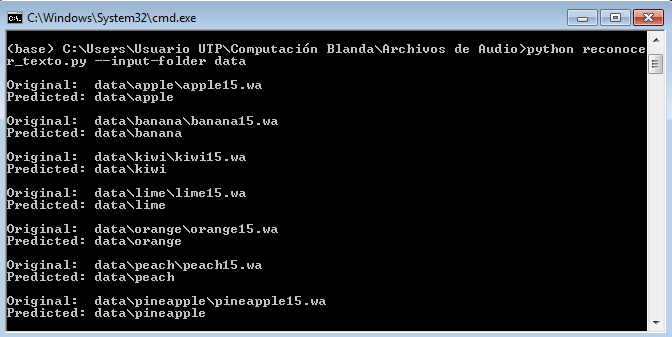